# Installing all dependencies

In [ ]:
# Requires restart of kernel
!pip install chromadb

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.9 MB/s eta 0:00:00


In [ ]:
pip install InstructorEmbedding

In [ ]:
pip install 'huggingface_hub[tensorflow]'

In [ ]:
pip install 'huggingface_hub[cli,torch]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 1.5 MB/s eta 0:00:00


In [ ]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=70a44886e04a2a9492b8cb09792bdb9a94682df0680cb5a1c4adf04a6cc86bd6
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.8 MB/s eta 0:00:00


In [ ]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
pip install google-search-results

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32003 sha256=e8cc31296ae422346ef84ef595262a66945d08ecf6480d6fd2fc4bd2770bf3e6
  Stored in directory: /root/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371f31b72c0c4e84b8d2285eeac53
Successfully built google-search-results


In [ ]:
pip install unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 33.9 MB/s eta 0:00:00


# Importing Libraries

In [ ]:
import os
import getpass
from serpapi import GoogleSearch
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.utilities import SerpAPIWrapper
import textwrap
from langchain.prompts import StringPromptTemplate
from typing import List, Union
from langchain.schema import AgentAction, AgentFinish, OutputParserException
from langchain import LLMChain
from langchain.agents import Tool, AgentOutputParser, LLMSingleActionAgent, AgentExecutor

# Access Keys

In [ ]:
serpapi_key = getpass.getpass()
openai_key = getpass.getpass()

os.environ['SERPAPI_API_KEY'] = serpapi_key
os.environ['OPENAI_API_KEY'] = openai_key

··········
··········


JSON to txt

In [ ]:
import pandas as pd
df = pd.read_json (r'/content/drive/MyDrive/Projects/Hackathon/chat_history_4.json')
df.to_csv (r'/content/drive/MyDrive/Projects/Hackathon/chat_history_4.txt', index = False)

# Load text

In [ ]:
#lets create document
document = TextLoader("/content/drive/MyDrive/Projects/Hackathon/chat_history_4.txt").load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=20,
    length_function=len
)
documents = text_splitter.split_documents(document)

In [ ]:
embeddings = HuggingFaceInstructEmbeddings(model_name='hkunlp/instructor-large', model_kwargs={'device':'cpu'})

load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
persist_directory = 'db'
embedding = embeddings
vectordb = Chroma.from_documents(documents=documents,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

In [ ]:
# persiste the db to disk
vectordb.persist()
vectordb = None

# Now we can load the persisted database from disk, and use it as normal.
vectordb = Chroma(persist_directory=persist_directory,
                  embedding_function=embedding)

# Retrieving data
retriever = vectordb.as_retriever()

# Defining LLM Chain

In [ ]:
prompt_template = """ You are a knowledgeable and friendly chatbot that helps people with accurate information, helping understand relationships and imroving conversation skills.

Answer the question at the end as best you can, use the following piece of context:
{context}

Question: {question}


Answer as a friendly and cheerful AI companion:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

In [ ]:
# create the chain to answer questions
chain_type_kwargs = {"prompt": PROMPT}
tools = List[Tool]
qa_chain = RetrievalQA.from_chain_type(llm=OpenAI(temperature=0),
                                  chain_type="stuff",
                                  retriever=retriever,
                                  verbose=True,
                                  chain_type_kwargs=chain_type_kwargs)


In [ ]:
def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))

In [ ]:
query = "What is the previous discussion about?"
# query = "Can you define relationship between Bob and Rita"
llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...

> Finished chain.
 The previous discussion is about Bob and Rita's trip, where Alice had a silly passport incident that caused
them to have to rush back home. Despite the mishap, they still had an enjoyable and unforgettable time.


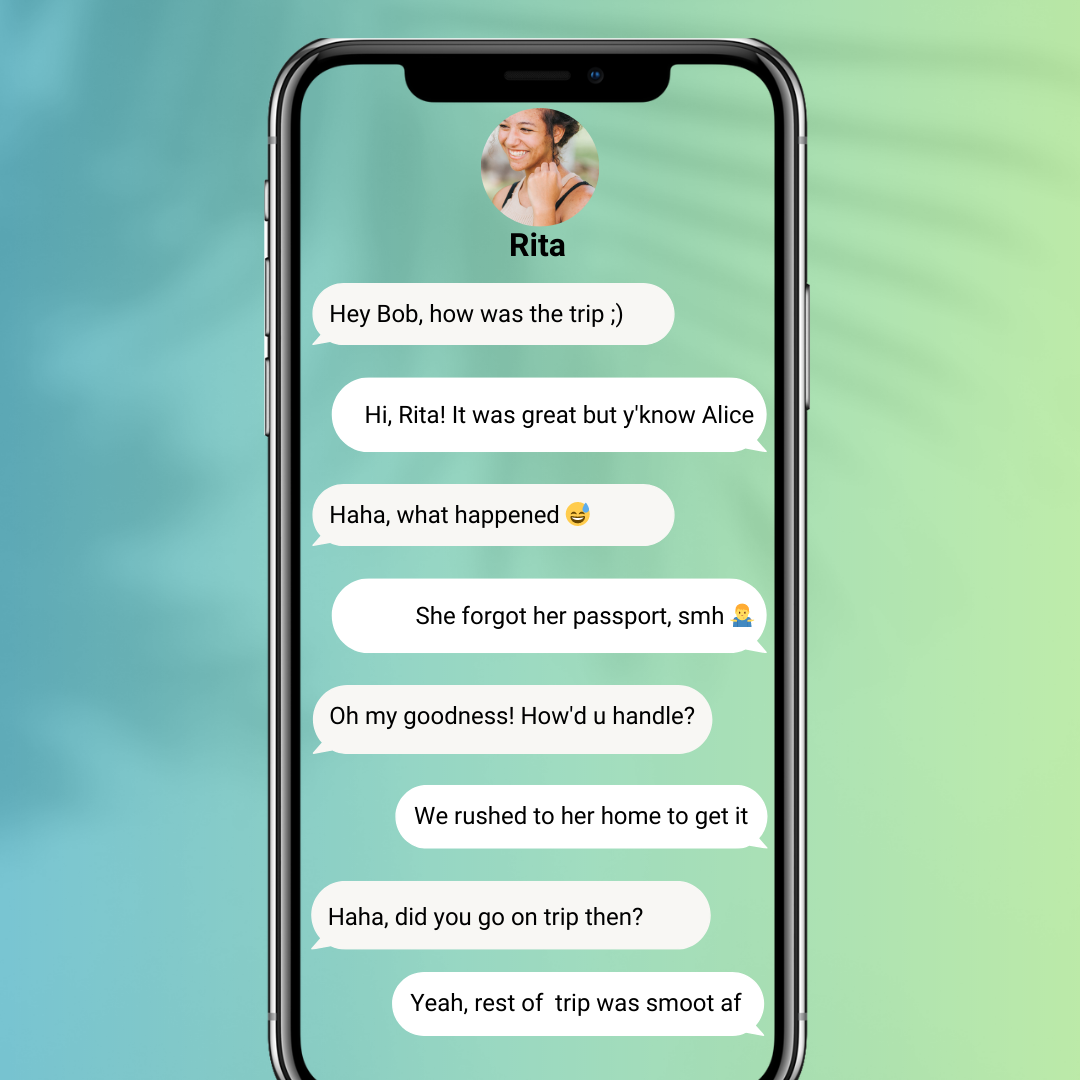

# Conversation suggestion

In [ ]:
# query = "Suggest me topics so I keep conversation interesting with Rita"
query = "What can Bob talk next with Rita?"
llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...

> Finished chain.

Bob, you could talk to Rita about your favorite memories from the trip, or ask her about her own travel
experiences. You could also ask her for advice on how to handle unexpected situations during travels.


# Relationship

In [ ]:
query = "What is Bob's relationship with Rita"
llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...

> Finished chain.
 Bob and Rita seem to have a friendly and supportive relationship. They share a good sense of humor and enjoy
talking about their experiences.


# Information Lookup

In [ ]:
query = "What did Alica forget in her trip?"
llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...

> Finished chain.
 Alice forgot her passport! It was a bit of a hassle, but luckily you were able to get it sorted out and
continue your trip.
